In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [2]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/01_Strains_AMLNtoControl_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

### Read in raw gene expression files

write raw peak files for each strain

In [3]:
best_reps = [
    '00_C57_Kupffer_H3K27Ac_control_young_C571A_170915',
    '00_C57_Kupffer_H3K27Ac_control_young_C572A_180423',
    '01_balbc_Kupffer_H3K27Ac_control_young_Balb10ABC_170915',
    '01_balbc_Kupffer_H3K27Ac_control_young_Balb11AB_170915',
    '02_aj_Kupffer_H3K27Ac_control_young_AJ10ABC_161208',
    '02_aj_Kupffer_H3K27Ac_control_young_AJ11AB_161208',
    '00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579A_180423',
    '00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579C_180423',
    '01_balbc_Kupffer_H3K27Ac_AMLNDiet_30weeks_Balb14D_180423',
    '01_balbc_Kupffer_H3K27Ac_AMLNDiet_30weeks_Balb6AB_180423',
    '02_aj_Kupffer_H3K27Ac_AMLNDiet_30weeks_AJ15B_180423',
    '02_aj_Kupffer_H3K27Ac_AMLNDiet_30weeks_AJ6A_180423']

In [4]:
df, mat = read_annotated_peaks('./ann_raw_kc_amln_atac_peaks_all.txt')

Check that we are selecting the proper samples and the column order since we need this info for running get diff expressssion.

In [6]:
strains = ['C57', 'balbc', 'aj']
df, mat = read_annotated_peaks('./ann_raw_kc_amln_atac_peaks_all.txt')
df.index.rename('PeakID')
# drop bad qc samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df = df.loc[:, tst]
mat = mat.loc[:, mat.columns.str.contains('|'.join(best_reps))]

for strain in strains:
    print(strain)
    # pull out selected strain
    tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains(strain))
    # print(tst)
    tmp = df.loc[:, tst]
    print(tmp.columns)
    tmp.to_csv('./'+strain+'_ann_raw_kc_amln_atac_peaks_all.txt', sep='\t')

C57
Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size', 'Annotation', 'Detailed Annotation',
       'Distance to TSS', 'Nearest PromoterID', 'Entrez ID', 'Nearest Unigene',
       'Nearest Refseq', 'Nearest Ensembl', 'Gene Name', 'Gene Alias',
       'Gene Description', 'Gene Type',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C571A_170915',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C572A_180423',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579A_180423',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579C_180423'],
      dtype='object')
balbc
Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size', 'Annotation', 'Detailed Annotation',
       'Dist

#### Run getDifferentialExpression for all samples

In [110]:
%%bash
source activate deseq_36
getDiffExpression.pl ./C57_ann_raw_kc_amln_atac_peaks_all.txt \
00_c57_control 00_c57_control \
01_c57_amln 01_c57_amln \
-peaks > ./C57_diff_output.txt


	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_c57_control vs. 01_c57_amln:
		Total Genes: 48031
		Total Up-regulated in 01_c57_amln vs. 00_c57_control: 3119 (6.494%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_c57_amln vs. 00_c57_control: 2489 (5.182%) [log2fold<-1, FDR<0.05]



In [112]:
%%bash
source activate deseq_36
getDiffExpression.pl ./balbc_ann_raw_kc_amln_atac_peaks_all.txt \
00_balbc_control 00_balbc_control \
01_balbc_amln 01_balbc_amln \
-peaks > ./balbc_diff_output.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_balbc_control vs. 01_balbc_amln:
		Total Genes: 48031
		Total Up-regulated in 01_balbc_amln vs. 00_balbc_control: 107 (0.223%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_balbc_amln vs. 00_balbc_control: 90 (0.187%) [log2fold<-1, FDR<0.05]



In [113]:
%%bash
source activate deseq_36
getDiffExpression.pl ./aj_ann_raw_kc_amln_atac_peaks_all.txt \
00_aj_control 00_aj_control \
00_aj_amln 00_aj_amln \
-peaks > ./aj_diff_output.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_aj_control vs. 00_aj_amln:
		Total Genes: 48031
		Total Up-regulated in 00_aj_amln vs. 00_aj_control: 1608 (3.348%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 00_aj_amln vs. 00_aj_control: 1038 (2.161%) [log2fold<-1, FDR<0.05]



# Extract differential peaks (activated and repressed) for each strain

# Select strain specific NASH regulated peaks

Also want to pull out background peaks for motif analysis using HOMER

In [15]:
import itertools
mylist = peak_dict.keys()
count = 0

spec_peak_dict = {}
# use pattern to extract cell type
for i, j in itertools.permutations(mylist, r=2):
    print(i, j)

    # since each strain has two pairwise comparisons with the other strains, we have to start a new list of peaks
    # every other count. then on the 'odd' counts we can use the set union 
    if (count % 2) == 0:
        # select upregulated peaks
        spec_peak_dict[i+'_act'] = set(peak_dict[i][0]).difference(peak_dict[j][0])
        spec_peak_dict[i+'_rep'] = set(peak_dict[i][1]).difference(peak_dict[j][1])

    elif (count % 2) == 1:
        # select activated and repressed peaks.
        # in this case though if we are using the "union" function i think
        # that it means we are not picking up strain specific peaks as much
        # as we are picking up strain specific peaks in at least one comparison ....
        spec_peak_dict[i+'_act'] = spec_peak_dict[i+'_act'].intersection(set(peak_dict[i][0]).difference(peak_dict[j][0]))
        spec_peak_dict[i+'_rep'] = spec_peak_dict[i+'_rep'].intersection(set(peak_dict[i][1]).difference(peak_dict[j][1]))
        print(len(spec_peak_dict[i+'_act']))
        print(len(spec_peak_dict[i+'_rep']))

    count+=1

C57 aj
C57 balbc
1844
1593
aj C57
aj balbc
544
366
balbc C57
balbc aj
17
12


In [29]:
if not os.path.isdir('./nash_activated_peaks'):
    os.mkdir('./nash_activated_peaks')
    
if not os.path.isdir('./nash_repressed_peaks'):
    os.mkdir('./nash_repressed_peaks')

### double check pairwise peaks with annotate peaks histogram

write out specific peak files  
make merged tag directories  
annotate specific peak files with merged tag directories  
plot

In [30]:
# set p value and log2fc
padj = 0.05
log2fc = 1

peak_dict = {}

for i in glob.glob('./*diff_output.txt'):
    diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
        i,
        './ann_norm_kc_amln_atac_peaks_all.txt')
    
    # extract distal peaks only
    diff_peak = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS']) >= 3000, :]
    
    # log2fc is in position -3, adj p value is in position -1
    # positive peaks are up in NASH, negative peaks are down in NASH
    act = diff_peak.loc[(diff_peak.iloc[:, -3] >= log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    rep = diff_peak.loc[(diff_peak.iloc[:, -3] <= -log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    
    # write out peaks
    # active peaks
    with open('./nash_activated_peaks/'+i.split('_')[0]+'_act_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt', 'w') as f:
        f.write('PeakID\n')
        for j in act:
            f.write(j)
        f.close()
        
    # active peaks background
    with open('./nash_activated_peaks/'+i.split('_')[0]+'_act_bg_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt', 'w') as f:
        f.write('PeakID\n')
        for j in diff_peak.loc[diff_peak.index.difference(act), :]:
            f.write(j)
        f.close()
    
    # repressed peaks
    with open('./nash_repressed_peaks/'+i.split('_')[0]+'_rep_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt', 'w') as f:
        f.write('PeakID\n')
        for j in rep:
            f.write(j)
        f.close()
    
    # repressed peaks background
    with open('./nash_repressed_peaks/'+i.split('_')[0]+'_rep_bg_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt', 'w') as f:
        f.write('PeakID\n')
        for j in diff_peak.loc[diff_peak.index.difference(rep), :]:
            f.write(j)
        f.close()
        
    peak_dict[i.split('_')[0].replace('./','')] = [act, rep]

annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)
annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)
annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)


make directory for strain specific peaks

In [16]:
if not os.path.isdir('./strain_spec_peaks'):
    os.mkdir('./strain_spec_peaks')

read in master atac seq file

In [17]:
atac_peaks = pd.read_csv('./kc_amln_atac_peaks_all.txt', sep='\t', index_col=0)

For every comparison in the dict write out a peak file

In [18]:
for i in spec_peak_dict.keys():
    atac_peaks.reindex(spec_peak_dict[i]).dropna(how='all').to_csv('./strain_spec_peaks/'+i+'_peaks.txt', sep='\t')

Make merged tag directories

In [177]:
%%bash

makeTagDirectory c57_control -d /gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C571A_170915/ /gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C572A_180423/ &
makeTagDirectory balb_control -d /gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb10ABC_170915/ /gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb11AB_170915/ &
makeTagDirectory aj_control -d /gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ10ABC_161208/ /gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ11AB_161208/ &
makeTagDirectory c57_amln -d /gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579A_180423/ /gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579C_180423/ &
makeTagDirectory balb_amln -d /gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/01_balbc_Kupffer_H3K27Ac_AMLNDiet_30weeks_Balb14D_180423/ /gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/01_balbc_Kupffer_H3K27Ac_AMLNDiet_30weeks_Balb6AB_180423/ &
makeTagDirectory aj_amln -d /gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/02_aj_Kupffer_H3K27Ac_AMLNDiet_30weeks_AJ15B_180423/ /gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/02_aj_Kupffer_H3K27Ac_AMLNDiet_30weeks_AJ6A_180423/

Process is interrupted.


Make multi wig hub from merged directories

In [72]:
!ls ./merged_tag_dirs/

aj_amln  aj_control  balb_amln	balb_control  c57_amln	c57_control


In [ ]:
makeMultiWigHub.pl hrb_strains_h3k27ac_control_controltoAMLN_merged mm10 -force -color \
228,26,28 228,26,28 \
55,126,184 55,126,184 \
77,175,74 77,175,74 \
-d ./merged_tag_dirs/*

In [19]:
if not os.path.isdir('./strain_spec_peaks_hist'):
    os.mkdir('./strain_spec_peaks_hist')

In [20]:
with open('./annotateHist.sh', 'w') as f:
    for i in glob.glob('./strain_spec_peaks/*'):
        print(i)
        ann_hist = ['annotatePeaks.pl', i, 'mm10', '-size', '4000', '-hist', '10',
                    '-d', ' '.join(np.sort(glob.glob('./merged_tag_dirs/*'))),
                    '>', i.replace('strain_spec_peaks', 'strain_spec_peaks_hist'),
                    '&\n']
        f.write(' '.join(ann_hist))

./strain_spec_peaks/balbc_act_peaks.txt
./strain_spec_peaks/balbc_rep_peaks.txt
./strain_spec_peaks/aj_rep_peaks.txt
./strain_spec_peaks/C57_rep_peaks.txt
./strain_spec_peaks/C57_act_peaks.txt
./strain_spec_peaks/aj_act_peaks.txt


#### Read in file to check columns for plotting

In [14]:
# df = pd.read_csv('./strain_spec_peaks_hist/C57_rep_peaks.txt', sep='\t')

In [21]:
cols = ['./merged_tag_dirs/aj_amln Coverage',
       './merged_tag_dirs/aj_control Coverage',
       './merged_tag_dirs/balb_amln Coverage',
       './merged_tag_dirs/balb_control Coverage',
       './merged_tag_dirs/c57_amln Coverage',
       './merged_tag_dirs/c57_control Coverage']
colors = ['#e41a1c',
          '#fbb4ae',
          '#377eb8',
          '#b3cde3',
          '#4daf4a',
          '#ccebc5']

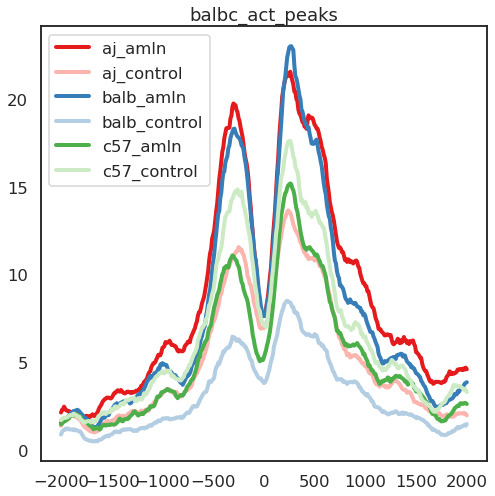

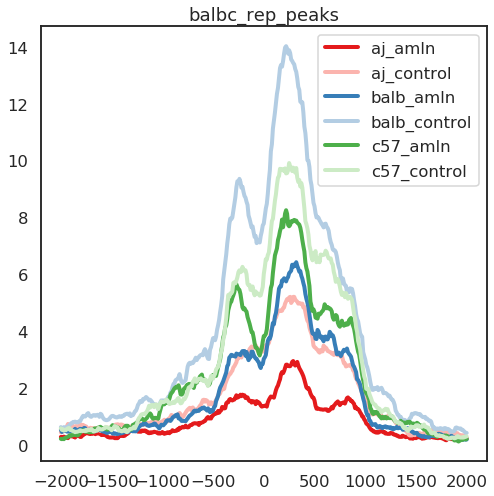

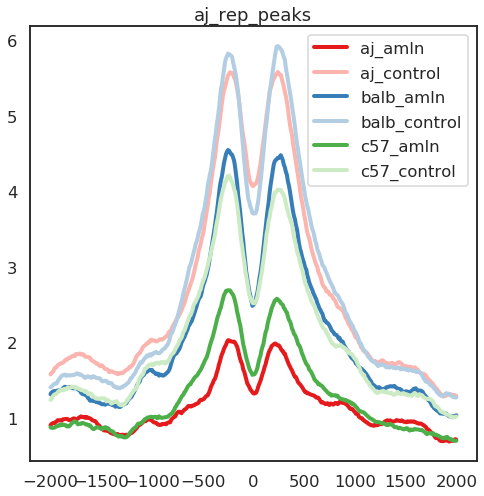

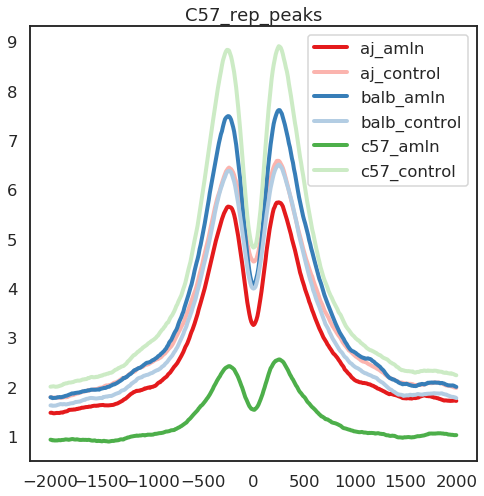

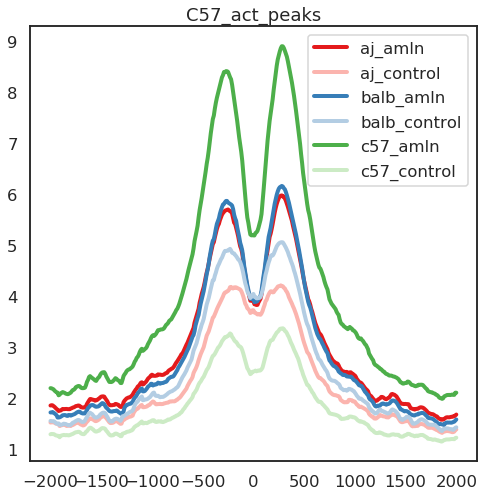

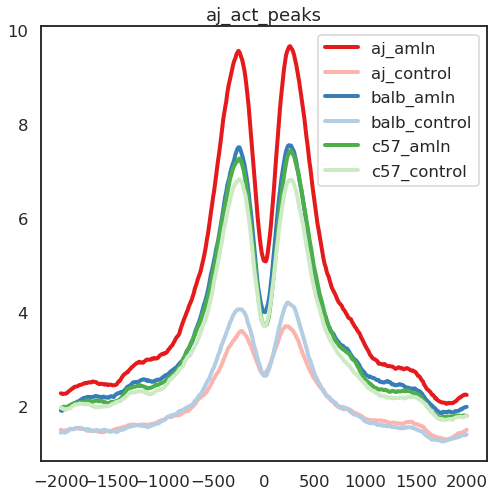

In [22]:
for i in os.listdir('./strain_spec_peaks_hist/'):

    df = pd.read_csv('./strain_spec_peaks_hist/'+i, sep='\t')

    fig, ax = plt.subplots(figsize=(8,8))
    for tags, color in zip(cols, colors):
        ax.plot(df.iloc[:, 0],
                df.loc[:, tags],
                c=color,
                linewidth=4,
                label=tags.split('/')[-1].replace(' Coverage', ''))
        ax.set_title(i.replace('.txt', ''))
        ax.legend()
    plt.savefig('./figures/'+i.replace('.txt', '_hist.png'), bbox_inches='tight')
    # plt.close()

# plot NASH associated changes in cistrome

In [23]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './C57_diff_output.txt',
    './ann_norm_kc_amln_atac_peaks_all.txt')

annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)


Check top peaks on browser to ensure everything worked properly

In [21]:
# diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)
# diff_peak.sort_values('00_c57_control vs. 01_c57_amln adj. p-value', ascending=True).head(5)

In [22]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

dict_keys(['00_c57_control vs. 01_c57_amln'])

In [23]:
comps = ['00_c57_control vs. 01_c57_amln']

cols = [[0,1,6,7]]

groups = [[[0,1],[6,7]]]

colors = [['#74c476', '#006d2c']]

00_c57_control vs. 01_c57_amln
N genes downregulated 2489
N genes upregulated 3119



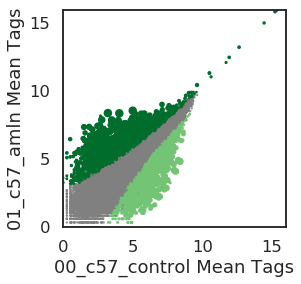

In [24]:
for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)))
    print('N genes upregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)))
    print('')
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    plt.subplots_adjust(wspace=0.5)

    axs[0].set_xlim(left=-np.ceil(np.max(np.abs(de.log2fc))),
                right=np.ceil(np.max(np.abs(de.log2fc))))
    axs[0].scatter(
        x=de.log2fc,
        y=de.logtpm,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)

    axs[0].set_ylabel('Mean Log2(TPM)')
    axs[0].set_xlabel('Log2FC')

    # plot group by group scatter:
    axs[1].scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    axs[1].set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    axs[1].set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    axs[1].set_xlim([0,np.ceil(countmax)])
    axs[1].set_ylim([0,np.ceil(countmax)])
                      
    plt.savefig('./figures/'+key+'_MAPlot_scatter.png', bbox_inches='tight')
    plt.close()
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

# Grab AJ specific enhancers

In [13]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './aj_diff_output.txt',
    './ann_norm_kc_amln_atac_peaks_all.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)


dict_keys(['00_aj_control vs. 00_aj_amln'])

In [14]:
comps = ['00_aj_control vs. 00_aj_amln']

cols = [[4,5,10,11]]

groups = [[[4,5],[10,11]]]

colors = [['#fb6a4a', '#a50f15']]

00_aj_control vs. 00_aj_amln
N genes downregulated 1038
N genes upregulated 1608



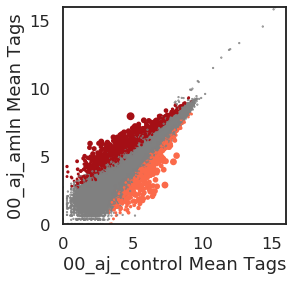

In [16]:
for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)))
    print('N genes upregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)))
    print('')
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    plt.subplots_adjust(wspace=0.5)

    axs[0].set_xlim(left=-np.ceil(np.max(np.abs(de.log2fc))),
                right=np.ceil(np.max(np.abs(de.log2fc))))
    axs[0].scatter(
        x=de.log2fc,
        y=de.logtpm,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)

    axs[0].set_ylabel('Mean Log2(TPM)')
    axs[0].set_xlabel('Log2FC')

    # plot group by group scatter:
    axs[1].scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    axs[1].set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    axs[1].set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    axs[1].set_xlim([0,np.ceil(countmax)])
    axs[1].set_ylim([0,np.ceil(countmax)])
                      
    plt.savefig('./figures/'+key+'_MAPlot_scatter.png', bbox_inches='tight')
    plt.close()
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

# Balbc Specific Peaks

In [17]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './balbc_diff_output.txt',
    './ann_norm_kc_amln_atac_peaks_all.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)


dict_keys(['00_balbc_control vs. 01_balbc_amln'])

In [18]:
comps = ['00_balbc_control vs. 01_balbc_amln']

cols = [[2,3,8,9]]

groups = [[[2,3],[8,9]]]

colors = [['#6baed6', '#08519c']]

00_balbc_control vs. 01_balbc_amln
N genes downregulated 90
N genes upregulated 107



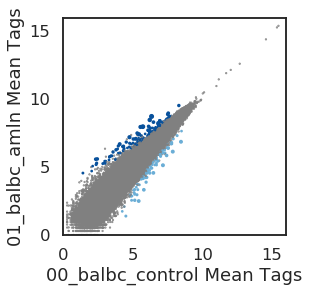

In [19]:
for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)))
    print('N genes upregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)))
    print('')
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    plt.subplots_adjust(wspace=0.5)

    axs[0].set_xlim(left=-np.ceil(np.max(np.abs(de.log2fc))),
                right=np.ceil(np.max(np.abs(de.log2fc))))
    axs[0].scatter(
        x=de.log2fc,
        y=de.logtpm,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)

    axs[0].set_ylabel('Mean Log2(TPM)')
    axs[0].set_xlabel('Log2FC')

    # plot group by group scatter:
    axs[1].scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    axs[1].set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    axs[1].set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    axs[1].set_xlim([0,np.ceil(countmax)])
    axs[1].set_ylim([0,np.ceil(countmax)])
                      
    plt.savefig('./figures/'+key+'_MAPlot_scatter.png', bbox_inches='tight')
    plt.close()
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

# Plot venn diagram of upregulated and downregulated peaks

In [24]:
from matplotlib_venn import venn3

In [25]:
all3 = set(peak_dict['C57'][0]).intersection(set(peak_dict['balbc'][0]).intersection(peak_dict['aj'][0]))
C57_balbc = set(peak_dict['C57'][0]).intersection(set(peak_dict['balbc'][0]).difference(all3))
C57_aj = set(peak_dict['C57'][0]).intersection(set(peak_dict['aj'][0]).difference(all3))
balbc_aj = set(peak_dict['balbc'][0]).intersection(peak_dict['aj'][0]).difference(all3)
C57_private = set(peak_dict['C57'][0]).difference(set(all3).union(set(C57_balbc).union(C57_aj)))
balbc_private = set(peak_dict['balbc'][0]).difference(set(all3).union(set(C57_balbc).union(balbc_aj)))
aj_private = set(peak_dict['aj'][0]).difference(set(all3).union(set(C57_aj).union(balbc_aj)))

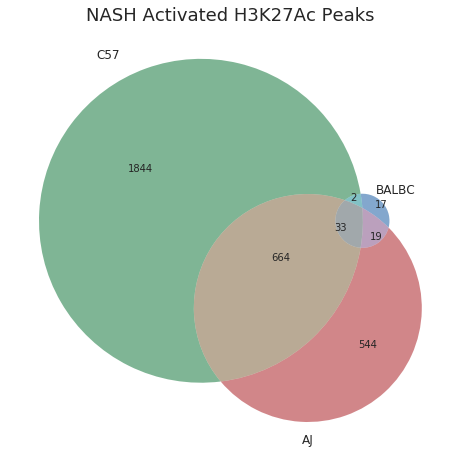

In [26]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=(len(C57_private),
               len(balbc_private),
               len(C57_balbc),
               len(aj_private),
               len(C57_aj),
               len(balbc_aj),
               len(all3)),
     ax=ax,
     set_colors=('#006d2c', '#08519c', '#a50f15'),
     set_labels=('C57', 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('NASH Activated H3K27Ac Peaks');

plt.savefig('./figures/venn3_activated_peaks.png', bbox_inches='tight')

In [27]:
all3 = set(peak_dict['C57'][1]).intersection(set(peak_dict['balbc'][1]).intersection(peak_dict['aj'][1]))
C57_balbc = set(peak_dict['C57'][1]).intersection(set(peak_dict['balbc'][1]).difference(all3))
C57_aj = set(peak_dict['C57'][1]).intersection(set(peak_dict['aj'][1]).difference(all3))
balbc_aj = set(peak_dict['balbc'][1]).intersection(peak_dict['aj'][1]).difference(all3)
C57_private = set(peak_dict['C57'][1]).difference(set(all3).union(set(C57_balbc).union(C57_aj)))
balbc_private = set(peak_dict['balbc'][1]).difference(set(all3).union(set(C57_balbc).union(balbc_aj)))
aj_private = set(peak_dict['aj'][1]).difference(set(all3).union(set(C57_aj).union(balbc_aj)))

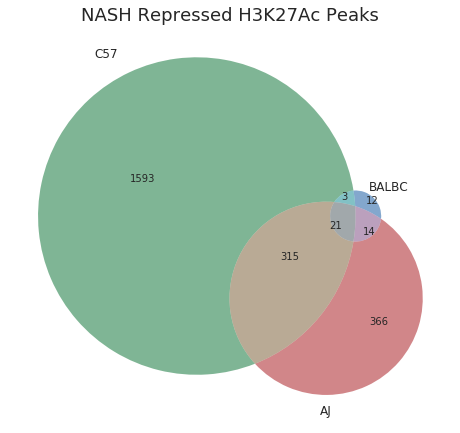

In [28]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=(len(C57_private),
               len(balbc_private),
               len(C57_balbc),
               len(aj_private),
               len(C57_aj),
               len(balbc_aj),
               len(all3)),
     ax=ax,
     set_colors=('#006d2c', '#08519c', '#a50f15'),
     set_labels=('C57', 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('NASH Repressed H3K27Ac Peaks');

plt.savefig('./figures/venn3_repressed_peaks.png', bbox_inches='tight')

### Check peaks in browser

In [68]:
atac_peaks.head()

,chr,start,end,strand,Stat,Parent files,Total subpeaks,./control_idr_peaks_merged.txt,./amln_idr_peaks_merged.txt,browser
#name (cmd = mergePeaks ./control_idr_peaks_merged.txt ./amln_idr_peaks_merged.txt),,,,,,,,,,
Merged-chr14-105669233-1,chr14,105669128,105669338,+,1000.0,./amln_idr_peaks_merged.txt,1,NaN,Merged-chr14-105669233-1,chr14:105669128-105669338
Merged-chr10-40437340-1,chr10,40437181,40437499,+,1000.0,./amln_idr_peaks_merged.txt,1,NaN,Merged-chr10-40437340-1,chr10:40437181-40437499
Merged-chr10-93161534-1,chr10,93161325,93161743,+,994.0,./amln_idr_peaks_merged.txt,1,NaN,Merged-chr10-93161520-2,chr10:93161325-93161743
Merged-chr10-81417005-1,chr10,81416894,81417117,+,1000.0,./amln_idr_peaks_merged.txt,1,NaN,Merged-chr10-81417005-1,chr10:81416894-81417117
Merged-chr4-117787141-1,chr4,117787035,117787248,+,1000.0,./amln_idr_peaks_merged.txt,1,NaN,Merged-chr4-117787141-1,chr4:117787035-117787248


In [69]:
atac_peaks['browser'] = atac_peaks.chr + ':' + atac_peaks.start.map(str) + '-' + atac_peaks.end.map(str)

In [75]:
atac_peaks.loc[balbc_private, 'browser'].head(10)

#name (cmd = mergePeaks ./control_idr_peaks_merged.txt ./amln_idr_peaks_merged.txt)
Merged-chr13-92335285-1       chr13:92335144-92335426
Merged-chr15-74920836-2       chr15:74920703-74920967
Merged-chr1-181138929-1      chr1:181138753-181139105
Merged-chr10-10480926-1       chr10:10480819-10481033
Merged-chr14-103059164-2    chr14:103059009-103059319
Merged-chr2-117304146-2      chr2:117303994-117304310
Merged-chr17-34257851-2       chr17:34257695-34258020
Merged-chr8-116627958-2      chr8:116627786-116628131
Merged-chr19-6871649-1          chr19:6871541-6871758
Merged-chr15-64278301-1       chr15:64278200-64278402
Name: browser, dtype: object

In [79]:
diff_peak.loc[aj_private, :].sort_values('00_aj_control vs. 00_aj_amln adj. p-value', ascending=True).head(10)

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,Gene Alias,Gene Description,Gene Type,/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ10ABC_161208,/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ11AB_161208,/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/02_aj_Kupffer_H3K27Ac_AMLNDiet_30weeks_AJ15B_180423,/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/02_aj_Kupffer_H3K27Ac_AMLNDiet_30weeks_AJ6A_180423,00_aj_control vs. 00_aj_amln Log2 Fold Change,00_aj_control vs. 00_aj_amln p-value,00_aj_control vs. 00_aj_amln adj. p-value
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr16-93914442-2,chr16,93913942,93914942,+,1000.0,./control_idr_peaks_merged.txt|./amln_idr_peak...,Intergenic,Intergenic,15125.0,NM_001165925,...,AI851731,claudin 14,protein-coding,6.057839,6.002976,7.504889,7.405222,2.863628,6.337859e-19,9.272507e-16
Merged-chr17-73972477-2,chr17,73971972,73972972,+,1000.0,./control_idr_peaks_merged.txt|./amln_idr_peak...,Intergenic,Intergenic,-22276.0,NM_011723,...,XO|Xor|Xox-1|Xox1,xanthine dehydrogenase,protein-coding,6.352765,6.453363,7.868318,7.682775,2.494461,2.222780e-17,2.357703e-14
Merged-chr16-10498313-1,chr16,10497813,10498813,+,986.0,./control_idr_peaks_merged.txt,"intron (NM_001302619, intron 2 of 19)","intron (NM_001302619, intron 2 of 19)",8532.0,NM_001243761,...,C2ta|EG669998|Gm9475|Mhc2ta,class II transactivator,protein-coding,6.498639,6.465723,7.851702,7.608098,2.266545,1.097600e-14,6.020819e-12
Merged-chr15-85653963-2,chr15,85653444,85654444,+,966.5,./control_idr_peaks_merged.txt|./amln_idr_peak...,Intergenic,Intergenic,-49829.0,NR_110483,...,Lincppara|Mirlet7bhg|linc-Ppara,long noncoding RNA near Ppara,ncRNA,6.648534,6.874442,7.858916,8.036686,2.018932,5.926436e-13,2.044283e-10
Merged-chr12-3823847-2,chr12,3823350,3824350,+,933.5,./control_idr_peaks_merged.txt|./amln_idr_peak...,"intron (NM_001271753, intron 1 of 22)","intron (NM_001271753, intron 1 of 22)",16690.0,NM_001271753,...,MmuIIIA,DNA methyltransferase 3A,protein-coding,7.811025,7.928537,8.883745,8.889154,1.470523,2.374158e-12,7.352612e-10
Merged-chr2-103683050-2,chr2,103682556,103683556,+,908.5,./control_idr_peaks_merged.txt|./amln_idr_peak...,"intron (NM_178890, intron 2 of 16)","intron (NM_178890, intron 2 of 16)",78214.0,NM_153126,...,AI429152,N-acetyltransferase 10,protein-coding,6.140030,5.914625,7.177988,7.176680,2.391227,2.510292e-12,7.662351e-10
Merged-chr4-58466901-1,chr4,58466401,58467401,+,1000.0,./control_idr_peaks_merged.txt,"intron (NM_172989, intron 3 of 3)","intron (NM_172989, intron 3 of 3)",-25803.0,NR_037278,...,mir-3095|mmu-mir-3095,microRNA 3095,ncRNA,5.992051,5.888166,7.033843,7.024408,2.364280,6.166686e-12,1.710066e-09
Merged-chr17-31003345-1,chr17,31002845,31003845,+,1000.0,./control_idr_peaks_merged.txt,"intron (NM_177465, intron 20 of 21)","intron (NM_177465, intron 20 of 21)",48662.0,NM_177465,...,D17Ertd488e,uromodulin-like 1,protein-coding,6.046122,6.245130,7.379796,7.183598,2.278496,1.146408e-11,3.002458e-09
Merged-chr6-106787354-1,chr6,106786854,106787854,+,1000.0,./control_idr_peaks_merged.txt,"intron (NM_021449, intron 5 of 10)","intron (NM_021449, intron 5 of 10)",12733.0,NM_021449,...,2610203G15Rik|2900045O07Rik|AF229032|AW108261|piL,cereblon,protein-coding,6.438673,6.809053,7.685243,7.908373,2.040094,6.819628e-11,1.468747e-08


### Cluster differential enhancers:

In [16]:
comps = ['00_c57 vs. 01_balbc',
         '00_c57 vs. 02_aj',
         '01_balbc vs. 02_aj']

In [18]:
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_id.extend(de.loc[de.adj_pval <= 0.05, :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)

In [19]:
sig_peaks = peak_mat.reindex(sig_peaks_id)

In [20]:
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

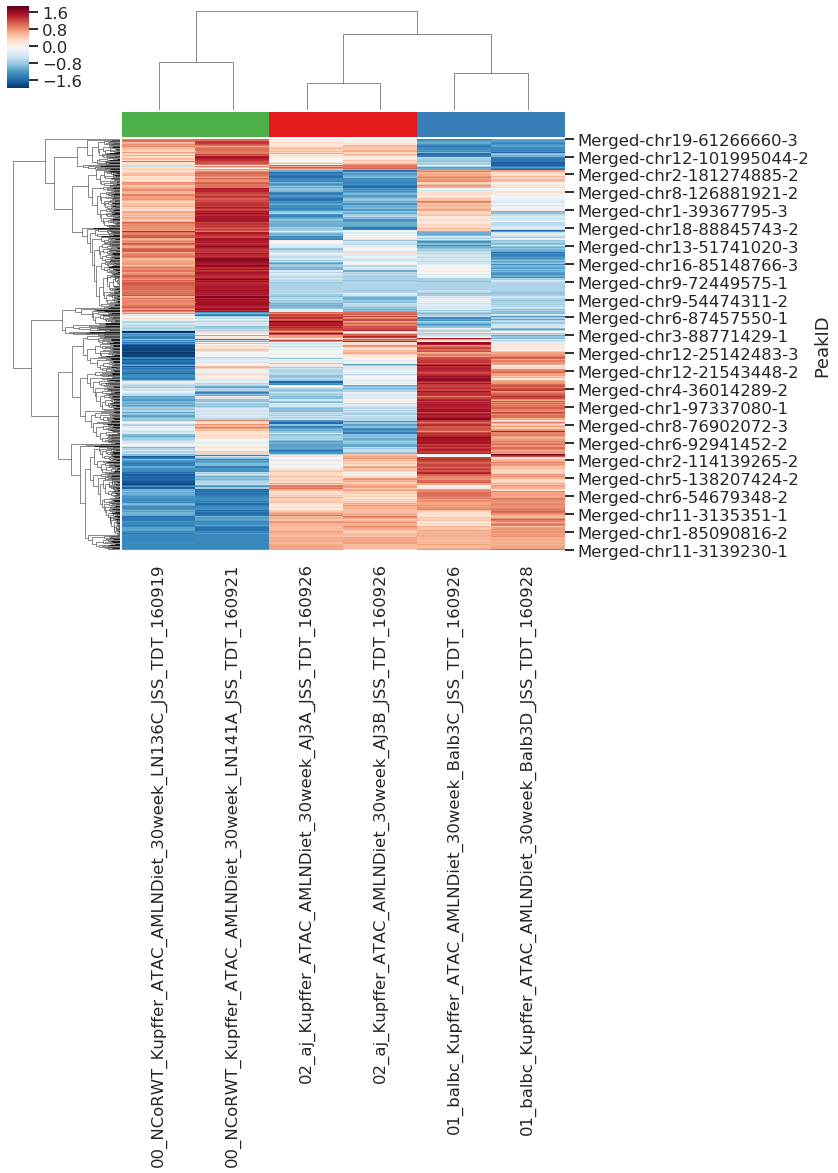

In [21]:
sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#4daf4a', '#4daf4a', '#377eb8', '#377eb8', '#e41a1c', '#e41a1c'])
plt.savefig('./figures/diff_peaks_clustermap.png', bbox_inches='tight')